# HackOn(Data)
## Competition Challenge

Welcome to our project. We have decided to do a simple Forecasting on the salesRank, more precesilly, 

** The problem:** Predict salesRank given the reviews information. 

** Hypothesis:** The reviews are an indicative of how well a product is selling and contain enough information for a forecast.

** Assumptions:** 

- We ommit that the data is seasonal.
- By product we mean the combination of product and vendors, that is represented by the asin.
- What else?

** NOTE: ** This notebook is intended to show the overall ideas and, in order to make it easier to read, we have sacrificed speed. The reader should go to the production file in order to find a faster version of what is discuss here.

This note is organized as follows:

- **Part 0**: Just the imports, that is the tools we will be using.
- **Part 1**: Cleaning and Preparing the Data. 
- **Part 2**: Feature Engineering.
- **Part 3**: Model Building.
- **Part 4**: Evaluating the results.
- **Part 5**: Scalability.

# Part 0 - Loading the tools

We load the tools we will be using during this project.

In [1]:
import pandas as pd
import numpy as np
import fasttext
import gzip
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import pickle

from collections import Counter

from sklearn.preprocessing import MultiLabelBinarizer #To be used with the categories feature
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score,mean_squared_error

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline  

/home/felipe/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


and we set some global variables

In [6]:
RELEVANT_KEY='Patio, Lawn & Garden'

# Part 1- Cleaning and preparing The Data

In this section we load the data, clean it, and prepare it for feature building. The data consists on

### **Review Data**

This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).

### **Q&A Data**

This dataset contains Questions and Answers data from Amazon, totaling around 1.4 million answered questions.

This dataset can be combined with Amazon product review data, by matching ASINs in the Q/A dataset with ASINs in the review data. The review data also includes product metadata (product titles etc.).

### **Credits:**

-  **R. He, J. McAuley**. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016 J. 
- ** McAuley, C. Targett, J. Shi, A. van den Hengel **. A Image-based recommendations on styles and substitutes. SIGIR, 2015


We start with the scripts provided at [Julian McAuley's website](http://jmcauley.ucsd.edu/data/amazon/).

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

and use these methods to load the data

In [4]:
df_reviews = getDF('./data/reviews_Patio_Lawn_and_Garden.json.gz')
df_meta=getDF('./data/meta_Patio_Lawn_and_Garden.json.gz')
df_qa=getDF('./data/qa_Patio_Lawn_and_Garden.json.gz')

We now study the different features.

In [5]:
df_meta.head()

,salesRank,related,imUrl,title,asin,categories,description,price,brand
0,{'Movies & TV': 231134},"{'also_viewed': ['0761149430', '0761120149', '...",http://ecx.images-amazon.com/images/I/51cNn5Dl...,"Primal Grill with Steven Raichlen, Volume One",0981850006,"[[Patio, Lawn & Garden, Grills & Outdoor Cooki...",Steven Raichlen's Best of Barbecue Primal Gril...,NaN,NaN
1,"{'Patio, Lawn & Garden': 188289}","{'also_viewed': ['B008WC0X0A', 'B000CPMOVG', '...",http://ecx.images-amazon.com/images/I/31B9X0S6...,Sand Shark Margare Maron Audio CD,144072007X,"[[Patio, Lawn & Garden, Lawn Mowers & Outdoor ...",The Tesoro Sand Shark metal combines time-prov...,577.15,Tesoro
2,"{'Patio, Lawn & Garden': 196610}","{'also_viewed': ['1554701511', '1554702720'], ...",http://ecx.images-amazon.com/images/I/51cTWw9d...,Napoleon's Everyday Plank Grilling,1554701503,"[[Patio, Lawn & Garden, Grills & Outdoor Cooki...",This definitive guide to incorporating planks ...,26.39,Napoleon
3,{'Toys & Games': 183251},"{'also_viewed': ['1250039479', '1250010160', '...",http://ecx.images-amazon.com/images/I/41nR62o%...,Bad Kitty Backpack Pull,1579822932,"[[Patio, Lawn & Garden, Picnic Baskets & Acces...",This is a Bad Kitty backpack pull clip.,3.65,Bad Kitty
4,"{'Patio, Lawn & Garden': 80211}","{'also_viewed': ['B005EN5008', 'B007ZU4BV2', '...",http://ecx.images-amazon.com/images/I/21cOwSPt...,5 pound SpaGuard Enhanced Spa Shock,1754164498,"[[Patio, Lawn & Garden, Pools, Hot Tubs & Supp...",Every spa needs to be shocked to eliminate und...,29.99,SpaGuard



## Features from the meta file

### SalesRank

Note that the dataframe that contains the salesRank is df_meta. In this data there are two possible cases where the values described are not helpful. The first one is a NaN value, and we can use is null method to deal with this, the second one is the case of a dictionary no containing the relevant key. We use a helper function to help us with this.

In [7]:
def helper(dictionary):
    try:
        return dictionary[RELEVANT_KEY]
    except:
        return float('NaN')

In [8]:
df_meta['salesRank']=df_meta.salesRank.map(lambda x: helper(x))

We can now count how many entries don't have the desired rank 
data.

In [9]:
df_meta.salesRank[(df_meta.salesRank.isnull())].shape[0]

15844

and proceed to remove these rows 

In [10]:
df_meta=df_meta[ df_meta.salesRank.notnull()]

We can do a sanity check 

In [11]:
df_meta.salesRank[(df_meta.salesRank.isnull())].shape[0]

0

### imUrl

This features contains the web address to an image. As ee won't be using the images, so we drop this column.

In [12]:
df_meta=df_meta.drop('imUrl',axis=1)

### Title and brand

From the fact that the percentage of articles with title or brands are

In [13]:
print("Only %.2f%% of the products have title."%(df_meta.title.count()/df_meta.asin.count()*100))
print("Only %.2f%% of the products have brand."%(df_meta.brand.count()/df_meta.asin.count()*100))

Only 99.99% of the products have title.
Only 40.66% of the products have brand.


We can deduce that this features are not relevant, and so we drop them as well.

In [14]:
df_meta=df_meta.drop(['title','brand'],axis=1)

### Price

The feature price is definitely relevant for the  forecasting, now note that 

In [15]:
print("%.2f%% of the products have a price."%(df_meta.price.count()*100/df_meta.asin.count()))

72.13% of the products have a price.


as this is a relevant feature we remove the rows with missing data.

In [16]:
df_meta=df_meta[df_meta.price.notnull()]

Another sanity check.

In [17]:
print("%.2f%% of the products have a price."%(df_meta.price.count()*100/df_meta.asin.count()))

100.00% of the products have a price.


After this cleaning 

In [18]:
print("There are %d products left"%df_meta.asin.count())

There are 67261 products left


### Categories

The categories feature comes as a list of lists, let's first find out how many different categories are there.

In [19]:
categories=set()
for list_cats in df_meta.categories:
    for list_cat in list_cats:
        categories=categories.union(set(list_cat))
categories=list(categories)
print("There are %d categories"%len(categories))

There are 601 categories


we use these as a categorial variable, first we create a unique list of categories for each product

In [20]:
def helper2(list_cats):
    cats=set()
    for list_cat in list_cats:
        cats=cats.union(set(list_cat))
    return list(cats)

In [21]:
df_meta['categories']=df_meta.categories.apply(helper2)

and then we use the [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from sklearn to do the encodding. 

In [22]:
mlb=MultiLabelBinarizer()
mlb.fit(df_meta.categories)
categories_df=pd.DataFrame(mlb.transform(df_meta.categories),columns=list(mlb.classes_))
df_meta.reset_index(drop=True,inplace=True)
df_meta=df_meta.merge(categories_df,left_index =True,right_index =True)

and finally we drop the categories column.

In [23]:
df_meta=df_meta.drop('categories',axis=1)

### related and decription

(ARE WE USING THIS?, RELATED MAY GIVE NICE INFO, BUT DESCRIPTION SEEMS USELESS)

We won't be using this either, so we remove them.

In [24]:
df_meta=df_meta.drop(['related','description'],axis=1)

## Features from the reviews file

### reviewText

This feature containing the review will be used for sentiment analysis. We come back to this when building features. For now, we just get rid of the data with empty reviews.

In [25]:
print("There are %d empty reviews."%df_reviews[df_reviews.reviewText==""].shape[0])
df_reviews=df_reviews[df_reviews.reviewText!=""]

There are 517 empty reviews.


### summary

We won't be using this feature, so we drop it

In [26]:
df_reviews=df_reviews.drop('summary',axis=1)

### reviewTime

This feature is redundant since we have unixReviewTime, so we also get rid of this

In [27]:
df_reviews=df_reviews.drop('reviewTime',axis=1)

### ReviewerName
This is also redundant, since we have the reviewerID, we drop it

In [28]:
df_reviews=df_reviews.drop('reviewerName',axis=1)

### Helpful
The helpful feature comes as a pair of integers, the first one represents the number of people who found the review helpful, the second one is the number of people giving an opinion on the review. We separate this info into two features.

In [29]:
df_reviews[['wasHelpful','helpfulFeedback']] = pd.DataFrame(df_reviews.helpful.values.tolist())

now the helpful feature is also redundant.

In [30]:
df_reviews=df_reviews.drop('helpful',axis=1)

## Features from QA data
We clean a couple features from the qa dataset. 

### answerType

There are three possibilities for the kind of answer Y,N, and ? so add this feature.

In [31]:
df_qa[['Y_answer','N_answer','?_answer']]=pd.get_dummies(df_qa.answerType)

and get rid of the superfluous feature answerType

In [32]:
df_qa=df_qa.drop('answerType',axis=1)

# Part 2 - Feature engineering

In this part we build our features, this will be done in the following order.


- Use sentiment analysis to give a sentiment score to the reviews. (Reason: a score of 3 for two people may mean different things the sentiment wil help correct this)

- helpful: Increases the confidence.

- ReviewerID features: will help us gain confidence in the review.

- ReviewTime: To create a time series for the (cummulative) number of reviews.

- Categories: Create category 'Other' and move everything that is not in the top 20 categories to the 'Other' category.


### Sentiment Analysis on reviews

We use [fasttext](https://github.com/facebookresearch/fastText) from facebook to create an score. This was build using 

A. Joulin, E. Grave, P. Bojanowski, T. Mikolov, Bag of Tricks for Efficient Text Classification

For this we need to save the data we need to a text file, since that is the signature of the training method of fasttext.

**Note:** We use a different algorithm in production. 

In [33]:
#df_sentiment=df_reviews.loc[:,('reviewText','overall')]
#df_sentiment['overall']=df_sentiment.overall.apply(lambda x: '__label__'+str(int(x)))
#df_sentiment.to_csv(r'./data_/data_for_sentiment.txt', header=None, index=None, sep=' ', mode='a')

Now, that the data is prepared for procesing, we can use the classifier.

In [34]:
#classifier = fasttext.supervised('./data_/data_for_sentiment.txt', 'model', label_prefix='__label__')
classifier=fasttext.load_model('model.bin')

and do a simple, sanity check

In [35]:
texts=["this is an awesome","this sucks"]
labels = classifier.predict(texts)
print(labels)

[['__label__5'], ['__label__1']]


and we can add this feature to the reviews dataframe

In [36]:
df_reviews['sentimentScore']=df_reviews.reviewText.apply(
    lambda x:int(classifier.predict([x])[0][0][-1]))

as that was our use of the textReview feature we can get rid of it.

We also pass a jugement to the review given the its lenght, compare to the score.

In [38]:
df_reviews['review_length']=df_reviews.reviewText.apply(lambda x:len(x))

In [39]:
df_reviews['review_judgment']=df_reviews.overall*(df_reviews.review_length-3)/2

In [40]:
df_reviews=df_reviews.drop('reviewText',axis=1)

### ReviewerID

We want to measure the quality of a review, so far we only have a values for this, the helpful feature. We add new features that come from the reviewerID. In order to obtain this features we create a new dataframe.

In [41]:
df_reviewers=df_reviews.merge(df_meta[['asin','price']],on='asin').groupby('reviewerID').agg({
                              'overall':['min','max','mean', 'std','count'], # details of ratings for this reviewer
                              'unixReviewTime':['min','max'], # date of first and last review
                              'wasHelpful': ['sum', 'min', 'max', 'mean', 'std'],
                              'helpfulFeedback':['sum', 'min', 'max', 'mean', 'std'],
                              'price': ['sum', 'min', 'max', 'mean', 'std'], # average price of items reviewed etc
                             })

We add this features to df_reviews.

In [42]:
#As we are choosing inner, this procedure automatically removes the items for which there's not price
df_reviews=df_reviews.merge(df_reviewers, left_on='reviewerID',right_index=True)

/home/felipe/anaconda3/lib/python3.5/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


as we won't be using the reviewerID anymore, we get rid of this feature.

In [43]:
df_reviews=df_reviews.drop('reviewerID',axis=1)

## Data aggregation

Before we continue with the feature generation, we need to agregate the data by product. This will make the features to be a time series, where the time is controled by the UnixReviewTime. We need to rename the columns first.

In [44]:
df_reviews.columns = [ col_name if isinstance(col_name,str) else "_".join(col_name) for col_name in df_reviews.columns]

and then create a dictionary that will help us obtain the aggregations that we want.

In [45]:
agg_ops_dict={feature_name:['sum', 'min', 'max', 'mean', 'std'] for feature_name in df_reviews.columns if feature_name!='asin'}
agg_ops_dict['unixReviewTime']+=[lambda x:(list(x))]
agg_ops_dict['overall']+=[lambda x:(list(x))]
agg_ops_dict['sentimentScore']+=[lambda x:(list(x))]
agg_ops_dict['wasHelpful']+=[lambda x:(list(x))]
agg_ops_dict['helpfulFeedback']+=[lambda x:(list(x))]

In [46]:
df_products=df_reviews.groupby('asin').agg(agg_ops_dict)

In [47]:
df_products.columns=[ "_".join(name) if name[1]!='<lambda>' else name[0] for name in df_products.columns]

### helpful

In order to incorporate the helpful score into the product, we create two variables defined below:

$$ \text{helpfulOverall} = \sum \text{overall}_i \cdot \frac{\text{wasHelpful}}{\text{helpfulFeedback}} $$ 

and 

$$ \text{helpfulSentiment} = \sum \text{sentiment_score}_i \cdot \frac{\text{wasHelpful}}{\text{helpfulFeedback}} $$ 
where the sums run over the $i$ such that helpful$_i$[1]$\neq 0$.

We need a helper function to incorporate these new features.

In [48]:
def helper_helpful(A,B,C):
    total=0
    for a,b,c in zip(A,B,C):
        if c!=0:
            total+=a*b/c
    return total

In [49]:
df_products['helpfulOverall']=df_products.apply(lambda row: helper_helpful(row['overall'],row['wasHelpful'],row['helpfulFeedback']),axis=1)
df_products['helpfulSentiment']=df_products.apply(lambda row: helper_helpful(row['sentimentScore'],row['wasHelpful'],row['helpfulFeedback']),axis=1)

and we can drop the helpful features now.

In [50]:
df_products=df_products.drop(['wasHelpful','helpfulFeedback'],axis=1)

The overall and sentimentScore feature are not necessary either. 

In [51]:
df_products=df_products.drop(['overall','sentimentScore'],axis=1)

**REMARK:** The reader should note that there is a faster way to compute the last two features, readly starting from the df_reviews dataframe building the individual multiplications and then aggregating. We opted for the (significantly) slower way to make the notebook easier to read.

### The hotness and density features.

We introduce a family of features designed to encode the behavior fo the cumulative function of number of reviews. We need to do some cleaning first.

As the unixReviewTime is the number of seconds since 1970, we simplify this so it keeps track of the number of days instead, we create a feature to keep track of the first day and modify the feature to keep track of the days after the first day that the review was created.

In [52]:
df_products['unixReviewTime']=df_products.unixReviewTime.apply(lambda x: np.sort(np.array(x)//3600//24))
df_products['firstReviewDay']=df_products.unixReviewTime.apply(lambda x:x[0])
df_products['daysSinceFirstReview']=df_products.unixReviewTime.apply(lambda x: x- x[0])

The feature unixReviewTime is now irrelevant

In [53]:
df_products=df_products.drop('unixReviewTime',axis=1)

we add a feature called productLife, keeping track of when the last review took place, and another feature for the number of reviews, nunmberReviews.

In [54]:
df_products['productLife']=df_products.daysSinceFirstReview.apply(lambda x:x[-1])
df_products['numberReviews']=df_products.daysSinceFirstReview.apply(lambda x: len(x))

To illustrate the next feature we are going to create, we graph the number of reviews against the days after the first review, for a sample set of reviews

In [55]:
def create_cumulative(days):
    X=[days[0]]
    Y=[0]
    current=0
    for day in days:
        if day==X[-1]:
            Y[current]+=1
        else:
            X.append(day)
            Y.append(Y[-1]+1)
            current+=1
    return X,Y

In [56]:
df_products.head()

,wasHelpful_sum,wasHelpful_min,wasHelpful_max,wasHelpful_mean,wasHelpful_std,helpfulFeedback_mean_sum,helpfulFeedback_mean_min,helpfulFeedback_mean_max,helpfulFeedback_mean_mean,helpfulFeedback_mean_std,...,helpfulFeedback_std_min,helpfulFeedback_std_max,helpfulFeedback_std_mean,helpfulFeedback_std_std,helpfulOverall,helpfulSentiment,firstReviewDay,daysSinceFirstReview,productLife,numberReviews
asin,,,,,,,,,,,,,,,,,,,,,
0981850006,6.0,6.0,6.0,6.000000,NaN,0.500000,0.5,0.500000,0.500000,NaN,...,0.707107,0.707107,0.707107,NaN,3.750000,3.750000,14509,[0],0,1
144072007X,17.0,1.0,15.0,5.666667,8.082904,23.000000,1.0,16.000000,7.666667,7.637626,...,NaN,NaN,NaN,NaN,9.854167,9.854167,13959,"[0, 1783, 1792]",1792,3
1554701503,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,15739,"[0, 45]",45,2
1754164498,1.0,0.0,1.0,0.333333,0.577350,0.666667,0.0,0.666667,0.222222,0.384900,...,0.577350,0.577350,0.577350,NaN,5.000000,5.000000,15880,"[0, 95, 273]",273,3
1880241064,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,15799,"[0, 68]",68,2


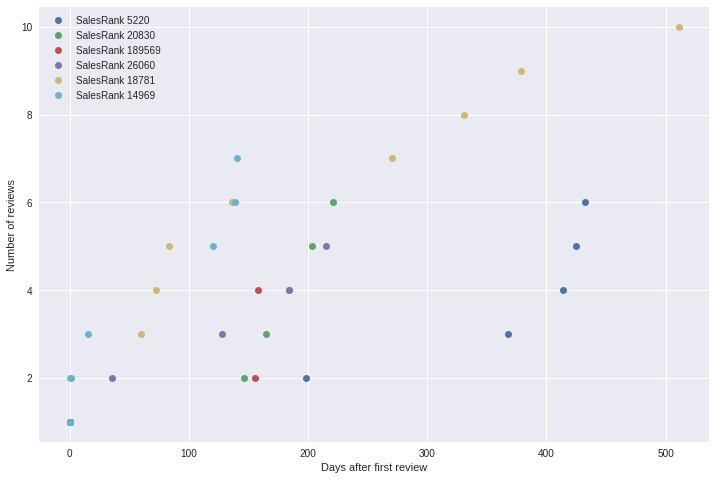

In [57]:
sample=df_products.merge(df_meta, left_index=True,right_on='asin').sample(6)
fig=plt.figure(figsize=(12,8))
for days,rank in zip(sample.daysSinceFirstReview,sample.salesRank):
    
    X,Y=create_cumulative(days)
    plt.plot(X, Y,'o',label="SalesRank %d"%rank)
    plt.legend(loc='best')

plt.xlabel("Days after first review")
plt.ylabel("Number of reviews")
plt.show()

Let's make the following assumption:

**Assumption: The "better" a product is, the more reviews it would have when measure over periods of time**

In order to make this concrete, we can create a new invariant, we define 

**hotness** = area under the staircase formed by the curve in the interval where it is defined.

Similarly we encode information of the product by its density, which relies on the assumption

**Assumption: The change on reviews per day is an indicative of the performance of the product. **

**density**= slope formed beteen the first point and a future point.

In [58]:
def compute_hotness(days):
    X,Y=create_cumulative(days)
    area_list=[0]
    area=0
    for i in range(1,len(X)):
        area+=(X[i]-X[i-1])*Y[i-1]
        area_list.append(area)
    area+=Y[-1]
    area_list.append(area)
    
    area_list = np.array(area_list)
    return area_list.max(),area_list.mean(),area_list.std()

Let's add this feature, for every day that has a a value.

In [59]:
df_products[['hotness_max','hotness_mean','hotness_std']] = pd.DataFrame(df_products.daysSinceFirstReview.apply(lambda x:compute_hotness(x)).values.tolist(),index=df_products.index)

We play the same game with density

In [60]:
def compute_density(days):
    X,Y=create_cumulative(days)
    slope_list=[Y[i]/X[i] for i in range(len(X)) if X[i]!=0 ]
    if len(slope_list)==0:
        return 0,0,0,0
    
    slope_list = np.array(slope_list)
    
    return slope_list.min(),slope_list.max(),slope_list.mean(),slope_list.std()

In [61]:
df_products[['density_min','density_max','density_mean','density_std']] = pd.DataFrame(df_products.daysSinceFirstReview.apply(lambda x:compute_density(x)).values.tolist(),index=df_products.index)

This concludes our feature creation, our next step is to set up the data for training.

## Counting questions

In [62]:
df_qa_agg = df_qa.groupby('asin').agg({
                              'asin':['count'], 
                              'unixTime':['min','max'],
                              'Y_answer': ['sum'],
                              'N_answer': ['sum'],
                              '?_answer': ['sum']
                             })

In [63]:
df_qa_agg.columns=['y_answer_sum','qa_unixTime_min','qa_unixTime_max','?_answer','qa_count','N_answer']

# Creating the X and y's

We want to create a dataset containing the features our models will use. We start by merging our meta_data to the products.

In [64]:
Xy_df=df_products.merge(df_meta, left_index=True,right_on='asin')
Xy_df=Xy_df.merge(df_qa_agg,how='outer',left_on='asin',right_index=True).fillna(0)

Let's take a look at the distribution of the salesRank data

In [65]:
#sns.distplot(Xy_df.salesRank, bins=20, kde=False, rug=True);

we could also check on this, by using the pandas method describe().

In [66]:
Xy_df.salesRank.describe()

count     67320.000000
mean     108849.518197
std      109646.250334
min           0.000000
25%       26589.750000
50%       76061.000000
75%      155407.500000
max      688490.000000
Name: salesRank, dtype: float64

This is, there is more data of lower ranks than of higer ranks, to deal with this will create bins each containing the same amount of data points. We need an auxiliary function.

In [67]:
salesRanks=np.sort(Xy_df.salesRank.as_matrix())
len_salesRank,=np.sort(Xy_df.salesRank.as_matrix()).shape
def find_breakpoints(nb_bins):
    step=len_salesRank//nb_bins
    return [salesRanks[i] for i in range(step-1,len_salesRank,step)]

and so we add many possible outcomes for the number of bins, we need an auxiliary function first.

In [68]:
def binning(breakpoints,a):
    i=0
    while i< len(breakpoints):
        if a>breakpoints[i]:
            i+=1
        else:
            return str(i+1)+"_out_of_"+str(len(breakpoints))
    return str(i+1)+"_out_of_"+str(len(breakpoints))

We now add the different bins, we go from 2 to 10.

In [69]:
for i in range(2,11):
    breakpoints=find_breakpoints(i)
    Xy_df['salesRank_Category_of_'+str(i)]=Xy_df.salesRank.apply(lambda x: binning(breakpoints,x))

we also create a relative rank

as all our desired data is here, we save this dataframe.

In [70]:
pickle.dump(Xy_df, open('./Xy_df_patio', 'wb'))

and we load it back

In [71]:
Xy_df=pickle.load(open('./Xy_df_patio', 'rb'))

In [72]:
Xy_df= Xy_df.drop(['daysSinceFirstReview'],axis=1)

We select the columns of features and the column of predictions

In [73]:
y_cats={}
for i in range(2,11):
    y_cats[i]=Xy_df['salesRank_Category_of_'+str(i)].as_matrix()
    
X_df=Xy_df.drop(['salesRank','asin']+['salesRank_Category_of_'+str(i) for i in range(2,11)],axis=1)
X=X_df.as_matrix()

now that we have the data we first separate it into train, validation, and test sets.

In [74]:
def train_test_val_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/0.9, random_state=13)
    return X_train,X_val,X_test,y_train,y_val,y_test

# Some models 

We create the models now

### Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
scores_RandomForest=[]
for i in range(2,11):
    print('Training for %d bins'%i,end='\r')
    X_train,X_val,X_test,y_train,y_val,y_test = train_test_val_split(X,y_cats[i])
    
    RandomForestModel = RandomForestClassifier(20)
    RandomForestModel.fit(X_train,y_train)
    scores_RandomForest.append(RandomForestModel.score(X_val,y_val))
    
    pickle.dump(RandomForestModel, open('./patio_RF_'+str(i), 'wb'))

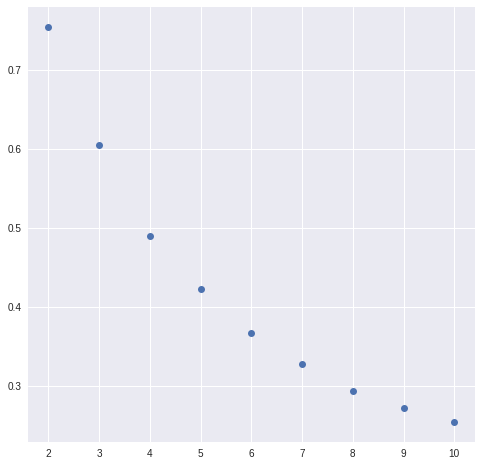

In [77]:
ax=plt.figure(figsize=(8,8))
plt.plot(list(range(2,11)),scores_RandomForest,'o')
plt.savefig("./RandomForestAccuracy_patio.png")
plt.show()

In [ ]:
#RandomForestModel = RandomForestRegressor()
#RandomForestModel.fit(X_train,y_train)
#X_df.columns[RandomForestModel.feature_importances_.argsort()[-30:][::-1]]
#RandomForestModel.score(X_val,y_val)
#np.sqrt(mean_squared_error(y_val,RandomForestModel.predict(X_val)))

### Xgboost

In [78]:
scores_XGB=[]
for i in range(2,11):
    print('Training for %d bins'%i,end='\r')
    X_train,X_val,X_test,y_train,y_val,y_test = train_test_val_split(X,y_cats[i])
    xgbModel = XGBClassifier()
    xgbModel.get_xgb_params()['num_class']=i
    xgbModel.get_xgb_params()['objective']="multi:softmax"
    xgbModel.fit(X_train,y_train,)
    scores_XGB.append(accuracy_score(y_val,xgbModel.predict(X_val)))
    
    pickle.dump(xgbModel, open('./videoGames_XGB_patio'+str(i), 'wb'))

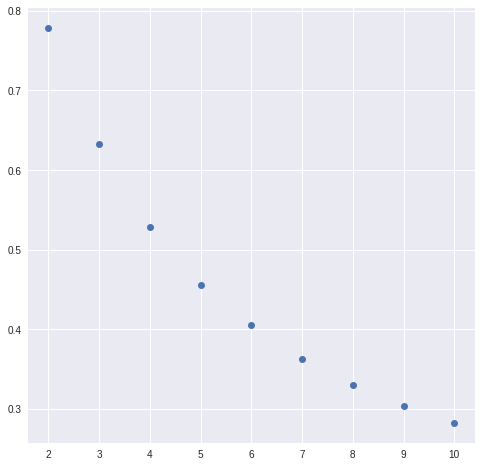

In [79]:
ax=plt.figure(figsize=(8,8))
plt.plot(list(range(2,11)),scores_XGB,'o')
plt.savefig("./XGBAccuracy_patio.png")
plt.show()

In [ ]:
scores_XGB

In [184]:
#X_train,X_val,X_test,y_train,y_val,y_test = train_test_val_split(X,y)
#modelX=xgb.XGBRegressor()
#modelX.fit(X_train,y_train,eval_metric='mae')
#print(r2_score(y_val,modelX.predict(X_val)))
#np.sqrt(mean_squared_error(y_val,modelX.predict(X_val)))

In [185]:
#modelX=xgb.XGBRegressor(max_depth=10,n_estimators=300)
#modelX.fit(X_train,y_train)
#print(r2_score(y_val,modelX.predict(X_val)))
#np.sqrt(mean_squared_error(y_val,modelX.predict(X_val)))